In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)

eSOH_DIR = "../data/esoh/"
oCV_DIR = "../data/ocv/"
hppc_DIR = "../data/hppc/"
crate_DIR = "../data/crate/"
cyc_DIR = "../data/cycling/"
fig_DIR = "../figures/figures_cycling/"
res_DIR = "../data/results/"

%matplotlib widget

In [2]:
spme = pybamm.lithium_ion.SPMe(
    {
        # "SEI": "ec reaction limited",
        # # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        # "lithium plating": "reversible",
    }
)
# spme.print_parameter_info()
param=spme.param

In [3]:
parameter_values = get_parameter_values()

In [4]:
parameter_values.search("radius")

Negative particle radius [m]	1e-05
Positive particle radius [m]	3.5e-06


In [5]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
print(cell_no)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spme,parameter_values)
cyc_data_raw = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
if int(cell_no)%3 == 1:
  cyc_data_raw = cyc_data_raw[ cyc_data_raw['Cycle number'] == 1 ]
else:
  cyc_data_raw = cyc_data_raw[ cyc_data_raw['Cycle number'] == 1 ]
cyc_data = cyc_data_raw.reset_index(drop=True)
t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
t_c1 = t_c1.values
I_c1 = cyc_data['Current [mA]']/1000
I_c1 = I_c1.values
V_c1 = cyc_data['Voltage [V]']
V_c1 = V_c1.values
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": 1.2676e-07,#2.7081e-07, #4.1759e-07,#2.7081e-07, #2.5112e-07,
        "Negative electrode LAM constant proportional term [s-1]": 1.2713e-06,#3.7576e-06, #3.2693e-06,#3.7576e-06, #2.4741e-06,
        "Positive electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        # "Initial temperature [K]": 273.15-5,
        # "Ambient temperature [K]": 273.15-5,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        "EC diffusivity [m2.s-1]": 8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        # "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity,
        # "Positive electrode diffusivity [m2.s-1]" NMC_diffusivity,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
        "Upper voltage cut-off [V]": 4.25,
    },
    check_already_exists=False,
)
t_sim = np.arange(0,t_c1[-1],1)
timescale = parameter_values.evaluate(spme.timescale)
current_interpolant = pybamm.Interpolant(
  #  drive_cycle[:, 0], drive_cycle[:, 1], timescale * pybamm.t
  t_c1, -I_c1, timescale * pybamm.t
)
pybamm.set_logging_level("NOTICE")
parameter_values["Current function [A]"] = current_interpolant
# var_pts=var_pts,
# sim0 = pybamm.Simulation(spme, 
#                         parameter_values=parameter_values, 
#                         solver=pybamm.CasadiSolver(
#                             mode="safe", 
#                             rtol=1e-6, 
#                             atol=1e-6,
#                             dt_max=10,
#                             )
#                         )
SOC_0 = 0.003
if cell>12:
  SOC_0 = 0.5
if cell==15:
  SOC_0 = 0.48
if cell==21:
  SOC_0 = 0.51
if cell in [13,16,19]:
  SOC_0 = 0.48
if cell==10:
  SOC_0 = 0.04
if cell in [14,17]:
  SOC_0 = 0.45
if cell==20:
  SOC_0 = 0.39
# sim0.solve(t_eval=t_sim,initial_soc =SOC_0)
# sol0 = sim0.solution
# t0 =  sol0["Time [s]"].entries
# V0 =  sol0["Terminal voltage [V]"].entries
# I0 =  sol0["Current [A]"].entries
# Q0 = -sol0['Discharge capacity [A.h]'].entries
# cs_sur_n0 =   sol0["X-averaged negative particle surface concentration"].entries
# cs_sur_p0 =   sol0["X-averaged positive particle surface concentration"].entries
# cs_ave_n0 =   sol0["Negative electrode volume-averaged concentration"].entries
# cs_ave_p0 =   sol0["Positive electrode volume-averaged concentration"].entries

01


In [6]:
def graphite_diffusivity(sto, T):
  from pybamm import exp, constants
  D_ref = 5.0* 10 ** (-15)
  E_D_s = 0
  arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
  return D_ref * arrhenius

def NMC_diffusivity(sto, T):
  from pybamm import exp, constants
  D_ref = 8 * 10 ** (-15)
  E_D_s = 0
  arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
  return D_ref * arrhenius

def electrolyte_diffusivity(c_e, T):
  from pybamm import exp, constants
  D_c_e = 5.35 * 10 ** (-10)
  E_D_e = 0
  arrhenius = exp(E_D_e /constants.R * (1 / 298.15 - 1 / T))
  return D_c_e * arrhenius

def electrolyte_conductivity(c_e, T):
    from pybamm import exp, constants
    sigma_e = 1.3
    E_k_e = 0
    arrhenius = exp(E_k_e / constants.R * (1 / 298.15 - 1 / T))
    return sigma_e * arrhenius

def graphite_electrolyte_exchange_current_density(c_e, c_s_surf, c_s_max, T):
  from pybamm import exp, constants
  m_ref = 1.061 * 10 ** (-6)  # unit has been converted
  # units are (A/m2)(mol/m3)**1.5 - includes ref concentrations
  E_r = 0#37480
  arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

  return (
      m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
  )

def NMC_electrolyte_exchange_current_density(c_e, c_s_surf, c_s_max, T):
  from pybamm import exp, constants
  m_ref = 4.824 * 10 ** (-6)  # (A/m2)(mol/m3)**1.5 - includes ref concentrations
  E_r = 0 #39570
  arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

  return (
      m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
  )

def NMC_entropic_change(sto, c_s_max):
  return 0
  
def graphite_entropic_change(sto, c_s_max):
  return 0

In [7]:
num1 = '^-6'
num2 = '^-7'

In [8]:
parameter_values.update(
    {
      # "Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity,
      # "Electrolyte conductivity [S.m-1]": electrolyte_conductivity,
      "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity,
      # "Positive electrode diffusivity [m2.s-1]": NMC_diffusivity,
      "Negative electrode exchange-current density [A.m-2]": graphite_electrolyte_exchange_current_density,
      # "Positive electrode exchange-current density [A.m-2]": NMC_electrolyte_exchange_current_density,
      # "Negative electrode OCP entropic change [V.K-1]": graphite_entropic_change,
      # "Positive electrode OCP entropic change [V.K-1]": NMC_entropic_change,
       "Negative particle radius [m]": 2.5e-6,
    },
    check_already_exists=False,
)

sim1 = pybamm.Simulation(spme, 
                        parameter_values=parameter_values, 
                        solver=pybamm.CasadiSolver(
                            mode="safe", 
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                            )
                        )
sim1.solve(t_eval=t_sim,initial_soc =SOC_0)
sol1 = sim1.solution
t1 =  sol1["Time [s]"].entries
V1 =  sol1["Terminal voltage [V]"].entries
I1 =  sol1["Current [A]"].entries
Q1 = -sol1['Discharge capacity [A.h]'].entries
cs_sur_n1 =   sol1["X-averaged negative particle surface concentration"].entries
cs_sur_p1 =   sol1["X-averaged positive particle surface concentration"].entries
cs_ave_n1 =   sol1["Negative electrode volume-averaged concentration"].entries
cs_ave_p1 =   sol1["Positive electrode volume-averaged concentration"].entries
sigma_ts_n1 = sol1["X-averaged negative particle surface tangential stress [Pa]"].entries
sigma_rs_n1 = sol1["X-averaged negative particle surface radial stress [Pa]"].entries
sigma_hs_n1 = (sigma_rs_n1 + 2 * sigma_ts_n1) / 3

In [9]:
V1_r = V1[I1<0]
l_idx = np.where(V1_r < 3.5)
h_idx = np.where(V1_r > 4)

In [10]:
def graphite_diffusivity1(sto, T):
  from pybamm import exp, constants
  D_ref = 16*5.0* 10 ** (-15)
  E_D_s = 0
  arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
  return D_ref * arrhenius

def NMC_diffusivity1(sto, T):
  from pybamm import exp, constants
  D_ref = 8 * 10 ** (-16)
  E_D_s = 0
  arrhenius = exp(E_D_s / constants.R * (1 / 298.15 - 1 / T))
  return D_ref * arrhenius

def graphite_electrolyte_exchange_current_density1(c_e, c_s_surf, c_s_max, T):
  from pybamm import exp, constants
  m_ref = 1.061*4* 10 ** (-6)  # unit has been converted
  # units are (A/m2)(mol/m3)**1.5 - includes ref concentrations
  E_r = 0#37480
  arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

  return (
      m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
  )

def NMC_electrolyte_exchange_current_density1(c_e, c_s_surf, c_s_max, T):
  from pybamm import exp, constants
  m_ref = 4.824 * 10 ** (-7)  # (A/m2)(mol/m3)**1.5 - includes ref concentrations
  E_r = 0 #39570
  arrhenius = exp(E_r / constants.R * (1 / 298.15 - 1 / T))

  return (
      m_ref * arrhenius * c_e**0.5 * c_s_surf**0.5 * (c_s_max - c_s_surf) ** 0.5
  )


In [11]:
1.061*3.8* 10 ** (-6) 

4.031799999999999e-06

In [12]:
parameter_values.update(
    {
      # "Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity1,
      # "Electrolyte conductivity [S.m-1]": electrolyte_conductivity1,
      "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity1,
      # "Positive electrode diffusivity [m2.s-1]": NMC_diffusivity1,
      "Negative electrode exchange-current density [A.m-2]": graphite_electrolyte_exchange_current_density1,
      # "Positive electrode exchange-current density [A.m-2]": NMC_electrolyte_exchange_current_density1,
      # "Negative electrode OCP entropic change [V.K-1]": graphite_entropic_change,
      # "Positive electrode OCP entropic change [V.K-1]": NMC_entropic_change,
      # "Initial temperature [K]": 273.15+25,
      # "Ambient temperature [K]": 273.15+25,
      "Negative particle radius [m]": 10e-6,
    },
    check_already_exists=False,
)

sim2 = pybamm.Simulation(spme, 
                        parameter_values=parameter_values, 
                        solver=pybamm.CasadiSolver(
                            mode="safe", 
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                            )
                        )
sim2.solve(t_eval=t_sim,initial_soc =SOC_0)
sol2 = sim2.solution
t2 =  sol2["Time [s]"].entries
V2 =  sol2["Terminal voltage [V]"].entries
I2 =  sol2["Current [A]"].entries
Q2 = -sol2['Discharge capacity [A.h]'].entries
cs_sur_n2 =   sol2["X-averaged negative particle surface concentration"].entries
cs_sur_p2 =   sol2["X-averaged positive particle surface concentration"].entries
cs_ave_n2 =   sol2["Negative electrode volume-averaged concentration"].entries
cs_ave_p2 =   sol2["Positive electrode volume-averaged concentration"].entries
sigma_ts_n2 = sol2["X-averaged negative particle surface tangential stress [Pa]"].entries
sigma_rs_n2 = sol2["X-averaged negative particle surface radial stress [Pa]"].entries
sigma_hs_n2 = (sigma_rs_n2 + 2 * sigma_ts_n2) / 3

In [13]:
V2_r = V2[:len(V1_r)]
high_rmse = 1000*np.sqrt(np.mean((V2[h_idx]-V1[h_idx])**2))
low_rmse = 1000*np.sqrt(np.mean((V2[l_idx]-V1[l_idx])**2))
total_rmse = 1000*np.sqrt(np.mean((V2_r-V1_r)**2))

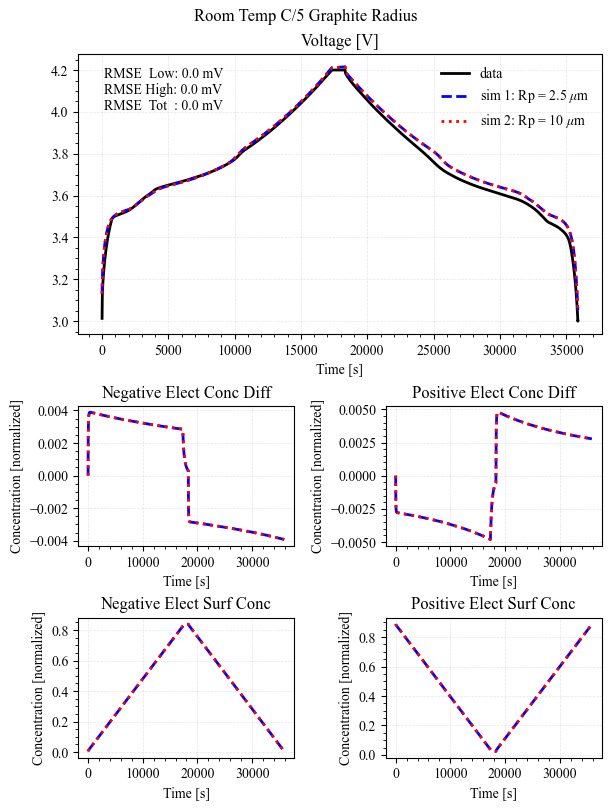

In [14]:
fig = plt.figure(figsize=(6, 8), constrained_layout = True)
gs = fig.add_gridspec(4,2)
ax1 = fig.add_subplot(gs[0:2,:])
ax1.plot(t_c1,V_c1,'k')
ax1.plot(t1,V1,'b--')
ax1.plot(t2,V2,'r:')
# ax1.plot(t3,V3,'c:')
ax1.set_title("Voltage [V]")
ax1.set_xlabel("Time [s]")
ax1.text(0.05,0.8,f'RMSE  Low: {low_rmse:0.1f} mV \nRMSE High: {high_rmse:0.1f} mV \nRMSE  Tot  : {total_rmse:0.1f} mV',transform=ax1.transAxes,fontsize=10)
# ax1.legend([
#             "data",
#             f"sim 1: Ds = {num1}",
#             f"sim 2: Ds = {num2}",
#             ])
ax1.legend([
            "data",
            r"sim 1: Rp = 2.5 $\mu$m",
            r"sim 2: Rp = 10 $\mu$m",
            ])
# ax1.legend([
#             "data",
#             f"sim 1: -5 C",
#             f"sim 2: 25 C",
#             f"sim 3: 45 C",
#             ])
ax2 = fig.add_subplot(gs[2,0])
ax2.plot(t1,cs_sur_n1-cs_ave_n1,'b--')
ax2.plot(t2,cs_sur_n2-cs_ave_n2,'r:')
# ax2.plot(t3,cs_sur_n3-cs_ave_n3,'c:')
ax2.set_title("Negative Elect Conc Diff")
ax2.set_ylabel("Concentration [normalized]")
ax2.set_xlabel("Time [s]")
ax3 = fig.add_subplot(gs[2,1])
ax3.plot(t1,cs_sur_p1-cs_ave_p1,'b--')
ax3.plot(t2,cs_sur_p2-cs_ave_p2,'r:')
# ax3.plot(t3,cs_sur_p3-cs_ave_p3,'c:')
ax3.set_ylabel("Concentration [normalized]")
ax3.set_title("Positive Elect Conc Diff")
ax3.set_xlabel("Time [s]")
ax4 = fig.add_subplot(gs[3,0])
ax4.plot(t1,cs_sur_n1,'b--')
ax4.plot(t2,cs_sur_n2,'r:')
# ax4.plot(t3,cs_sur_n3,'c:')
ax4.set_title("Negative Elect Surf Conc")
ax4.set_ylabel("Concentration [normalized]")
ax4.set_xlabel("Time [s]")
ax5 = fig.add_subplot(gs[3,1])
ax5.plot(t1,cs_sur_p1,'b--')
ax5.plot(t2,cs_sur_p2,'r:')
# ax5.plot(t3,cs_sur_p3,'c:')
ax5.set_ylabel("Concentration [normalized]")
ax5.set_title("Positive Elect Surf Conc")
ax5.set_xlabel("Time [s]")
# fig.suptitle("Cold Temp C/5 Graphite NMC Diffusivity, Exchange Current",horizontalalignment='right')
# plt.savefig(fig_DIR + 'cell_'+cell_no+f'_graphite_nmc_diffusivity_exchange.png')
# fig.suptitle("Cold Temp C/5 Graphite Diffusivity")
fig.suptitle("Room Temp C/5 Graphite Radius")
plt.savefig(fig_DIR + 'cell_'+cell_no+f'_graphite_radius_10um_i_2.png')

In [15]:
asdasd

NameError: name 'asdasd' is not defined

In [ ]:
plt.figure()
plt.plot(t1,sigma_hs_n1/1e6,'r')
plt.plot(t2,sigma_hs_n2/1e6,'b--')
plt.xlim(left=0)
plt.xlabel('Time [s]')
plt.ylabel('Stress [MPa]')
plt.title('Negative Electrode Surface Tangential Stress')
plt.legend(['Room','Hot','Cold'])
plt.savefig(fig_DIR + 'cell_'+cell_no+f'_graphite_radius_stress.png')

In [ ]:
dfsdfsd

In [ ]:
dfsdfsdrfsdf

# Crate Simulations

In [ ]:
crate_data_raw = pd.read_csv(crate_DIR+'crate_data_cell_'+cell_no+'.csv')
crate_data_raw = crate_data_raw[ crate_data_raw['Cycle number'] == 0 ]
crate_data = crate_data_raw

In [ ]:
t_d1 = crate_data['Time [s]']-crate_data['Time [s]'][0]
t_d1 = t_d1.values
I_d1 = crate_data['Current [mA]']/1000
I_d1 = I_d1.values
V_d1 = crate_data['Voltage [V]']
V_d1 = V_d1.values

In [ ]:
idx_I = np.where(np.sign(I_d1[:-1]) != np.sign(I_d1[1:]))[0] + 1
idx_I = idx_I[idx_I>50]

In [ ]:
# C/10
nn = 0
t_d1_c10 = t_d1[idx_I[nn+0]:idx_I[nn+1]]-t_d1[idx_I[nn+0]]
I_d1_c10 = I_d1[idx_I[nn+0]:idx_I[nn+1]]
V_d1_c10 = V_d1[idx_I[nn+0]:idx_I[nn+1]]
# C/5
nn = 4
t_d1_c5 = t_d1[idx_I[nn+0]:idx_I[nn+1]]-t_d1[idx_I[nn+0]]
I_d1_c5 = I_d1[idx_I[nn+0]:idx_I[nn+1]]
V_d1_c5 = V_d1[idx_I[nn+0]:idx_I[nn+1]]
# C/2
nn = 8
t_d1_c2 = t_d1[idx_I[nn+0]:idx_I[nn+1]]-t_d1[idx_I[nn+0]]
I_d1_c2 = I_d1[idx_I[nn+0]:idx_I[nn+1]]
V_d1_c2 = V_d1[idx_I[nn+0]:idx_I[nn+1]]
# 1C
nn = 12
t_d1_c1 = t_d1[idx_I[nn+0]:idx_I[nn+1]]-t_d1[idx_I[nn+0]]
I_d1_c1 = I_d1[idx_I[nn+0]:idx_I[nn+1]]
V_d1_c1 = V_d1[idx_I[nn+0]:idx_I[nn+1]]

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(6, 6))
ax1 = axes.flat[0]
ax1.plot(t_d1,I_d1)
ax1.plot(t_d1[idx_I],I_d1[idx_I],'rx')
ax2 = axes.flat[1]
ax2.plot(t_d1,V_d1)
ax2.plot(t_d1[idx_I],V_d1[idx_I],'rx')


In [ ]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
print(cell_no)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spme,parameter_values)
cyc_data_raw = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
if int(cell_no)%3 == 1:
  cyc_data_raw = cyc_data_raw[ cyc_data_raw['Cycle number'] == 1 ]
else:
  cyc_data_raw = cyc_data_raw[ cyc_data_raw['Cycle number'] == 1 ]
cyc_data = cyc_data_raw.reset_index(drop=True)
t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
t_c1 = t_c1.values
I_c1 = cyc_data['Current [mA]']/1000
I_c1 = I_c1.values
V_c1 = cyc_data['Voltage [V]']
V_c1 = V_c1.values
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Positive electrode LAM constant proportional term [s-1]": 1.2676e-07,#2.7081e-07, #4.1759e-07,#2.7081e-07, #2.5112e-07,
        "Negative electrode LAM constant proportional term [s-1]": 1.2713e-06,#3.7576e-06, #3.2693e-06,#3.7576e-06, #2.4741e-06,
        "Positive electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        # "Initial temperature [K]": 273.15-5,
        # "Ambient temperature [K]": 273.15-5,
        "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        "EC diffusivity [m2.s-1]": 8.30909086e-19,
        "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        # "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity,
        # "Positive electrode diffusivity [m2.s-1]" NMC_diffusivity,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
        "Upper voltage cut-off [V]": 4.25,
    },
    check_already_exists=False,
)
t_sim = np.arange(0,t_c1[-1],1)
timescale = parameter_values.evaluate(spme.timescale)
current_interpolant = pybamm.Interpolant(
  #  drive_cycle[:, 0], drive_cycle[:, 1], timescale * pybamm.t
  t_c1, -I_c1, timescale * pybamm.t
)
pybamm.set_logging_level("NOTICE")
parameter_values["Current function [A]"] = current_interpolant
# var_pts=var_pts,
# sim0 = pybamm.Simulation(spme, 
#                         parameter_values=parameter_values, 
#                         solver=pybamm.CasadiSolver(
#                             mode="safe", 
#                             rtol=1e-6, 
#                             atol=1e-6,
#                             dt_max=10,
#                             )
#                         )
SOC_0 = 0.003
if cell>12:
  SOC_0 = 0.5
if cell==15:
  SOC_0 = 0.48
if cell==21:
  SOC_0 = 0.51
if cell in [13,16,19]:
  SOC_0 = 0.48
if cell==10:
  SOC_0 = 0.04
if cell in [14,17]:
  SOC_0 = 0.45
if cell==20:
  SOC_0 = 0.39
# sim0.solve(t_eval=t_sim,initial_soc =SOC_0)
# sol0 = sim0.solution
# t0 =  sol0["Time [s]"].entries
# V0 =  sol0["Terminal voltage [V]"].entries
# I0 =  sol0["Current [A]"].entries
# Q0 = -sol0['Discharge capacity [A.h]'].entries
# cs_sur_n0 =   sol0["X-averaged negative particle surface concentration"].entries
# cs_sur_p0 =   sol0["X-averaged positive particle surface concentration"].entries
# cs_ave_n0 =   sol0["Negative electrode volume-averaged concentration"].entries
# cs_ave_p0 =   sol0["Positive electrode volume-averaged concentration"].entries

In [ ]:
experiment = pybamm.Experiment(
    [
        "Charge at "+"C/10"+" until 4.2V", 
         
    ],
)
sim = pybamm.Simulation(spme,experiment=experiment ,parameter_values=parameter_values, solver=pybamm.CasadiSolver(mode="safe"))
sim.solve(initial_soc =0)
solution1 = sim.solution

experiment = pybamm.Experiment(
    [
        "Charge at "+"C/5"+" until 4.2V", 
         
    ],
)
sim = pybamm.Simulation(spme,experiment=experiment ,parameter_values=parameter_values, solver=pybamm.CasadiSolver(mode="safe"))
sim.solve(initial_soc =0)
solution2 = sim.solution

experiment = pybamm.Experiment(
    [
        "Charge at "+"C/2"+" until 4.2V", 
         
    ],
)
sim = pybamm.Simulation(spme,experiment=experiment ,parameter_values=parameter_values, solver=pybamm.CasadiSolver(mode="safe"))
sim.solve(initial_soc =0)
solution3 = sim.solution

experiment = pybamm.Experiment(
    [
        "Charge at "+"1C"+" until 4.2V", 
         
    ],
)
sim = pybamm.Simulation(spme,experiment=experiment ,parameter_values=parameter_values, solver=pybamm.CasadiSolver(mode="safe"))
sim.solve(initial_soc =0)
solution4 = sim.solution

In [ ]:
t1 =  solution1["Time [s]"].entries
V1 =  solution1["Terminal voltage [V]"].entries
I1 =  solution1["Current [A]"].entries
Q1 = -solution1['Discharge capacity [A.h]'].entries

t2 =  solution2["Time [s]"].entries
V2 =  solution2["Terminal voltage [V]"].entries
I2 =  solution2["Current [A]"].entries
Q2 = -solution2['Discharge capacity [A.h]'].entries

t3 =  solution3["Time [s]"].entries
V3 =  solution3["Terminal voltage [V]"].entries
I3 =  solution3["Current [A]"].entries
Q3 = -solution3['Discharge capacity [A.h]'].entries

t4 =  solution4["Time [s]"].entries
V4 =  solution4["Terminal voltage [V]"].entries
I4 =  solution4["Current [A]"].entries
Q4 = -solution4['Discharge capacity [A.h]'].entries

In [ ]:
parameter_values.update(
    {
      # "Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity1,
      # "Electrolyte conductivity [S.m-1]": electrolyte_conductivity1,
      "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity1,
      # "Positive electrode diffusivity [m2.s-1]": NMC_diffusivity1,
      "Negative electrode exchange-current density [A.m-2]": graphite_electrolyte_exchange_current_density1,
      # "Positive electrode exchange-current density [A.m-2]": NMC_electrolyte_exchange_current_density1,
      # "Negative electrode OCP entropic change [V.K-1]": graphite_entropic_change,
      # "Positive electrode OCP entropic change [V.K-1]": NMC_entropic_change,
      # "Initial temperature [K]": 273.15+25,
      # "Ambient temperature [K]": 273.15+25,
      "Negative particle radius [m]": 10e-6,
    },
    check_already_exists=False,
)

In [ ]:
experiment = pybamm.Experiment(
    [
        "Charge at "+"C/10"+" until 4.2V", 
         
    ],
)
sim = pybamm.Simulation(spme,experiment=experiment ,parameter_values=parameter_values, solver=pybamm.CasadiSolver(mode="safe"))
sim.solve(initial_soc =0)
solution1_2 = sim.solution

experiment = pybamm.Experiment(
    [
        "Charge at "+"C/5"+" until 4.2V", 
         
    ],
)
sim = pybamm.Simulation(spme,experiment=experiment ,parameter_values=parameter_values, solver=pybamm.CasadiSolver(mode="safe"))
sim.solve(initial_soc =0)
solution2_2 = sim.solution

experiment = pybamm.Experiment(
    [
        "Charge at "+"C/2"+" until 4.2V", 
         
    ],
)
sim = pybamm.Simulation(spme,experiment=experiment ,parameter_values=parameter_values, solver=pybamm.CasadiSolver(mode="safe"))
sim.solve(initial_soc =0)
solution3_2 = sim.solution

experiment = pybamm.Experiment(
    [
        "Charge at "+"1C"+" until 4.2V", 
         
    ],
)
sim = pybamm.Simulation(spme,experiment=experiment ,parameter_values=parameter_values, solver=pybamm.CasadiSolver(mode="safe"))
sim.solve(initial_soc =0)
solution4_2 = sim.solution

In [ ]:
t1_2 =  solution1_2["Time [s]"].entries
V1_2 =  solution1_2["Terminal voltage [V]"].entries
I1_2 =  solution1_2["Current [A]"].entries
Q1_2 = -solution1_2['Discharge capacity [A.h]'].entries

t2_2 =  solution2_2["Time [s]"].entries
V2_2 =  solution2_2["Terminal voltage [V]"].entries
I2_2 =  solution2_2["Current [A]"].entries
Q2_2 = -solution2_2['Discharge capacity [A.h]'].entries

t3_2 =  solution3_2["Time [s]"].entries
V3_2 =  solution3_2["Terminal voltage [V]"].entries
I3_2 =  solution3_2["Current [A]"].entries
Q3_2 = -solution3_2['Discharge capacity [A.h]'].entries

t4_2 =  solution4_2["Time [s]"].entries
V4_2 =  solution4_2["Terminal voltage [V]"].entries
I4_2 =  solution4_2["Current [A]"].entries
Q4_2 = -solution4_2['Discharge capacity [A.h]'].entries

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
ax1 = axes.flat[0]
ax2 = axes.flat[1]
ax3 = axes.flat[2]
ax4 = axes.flat[3]
ax1.plot(t_d1_c10, V_d1_c10, 'k', t1, V1, 'b.', t1_2, V1_2, 'r--')
ax2.plot(t_d1_c5, V_d1_c5, 'k'  , t2, V2, 'b.', t2_2, V2_2, 'r--')
ax3.plot(t_d1_c2, V_d1_c2, 'k'  , t3, V3, 'b.', t3_2, V3_2, 'r--')
ax4.plot(t_d1_c1, V_d1_c1, 'k'  , t4, V4, 'b.', t4_2, V4_2, 'r--')
ax1.set_title('C/10')
ax2.set_title('C/5')
ax3.set_title('C/2')
ax4.set_title('1C')
ax1.set_ylabel("Voltage [V]")
ax3.set_ylabel("Voltage [V]")
# ax1.set_ylim([3.9,4.12])
ax3.set_xlabel("Time [s]")
ax4.set_xlabel("Time [s]")
# ax1.set_xlim([20370,20470])
ax1.legend([
            "data",
            r"sim 1: Rp = 2.5 $\mu$m",
            r"sim 2: Rp = 10 $\mu$m",
            ])
fig.tight_layout()
plt.show()
plt.savefig('cell_01_crate_fit.png')
plt.savefig(fig_DIR + 'cell_'+cell_no+f'_graphite_radius_10um_crate_comp.png')

# HPPC Sim

In [ ]:
cell = 1
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
print(cell_no)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spme,parameter_values)
cyc_data_raw = pd.read_csv(cyc_DIR+'cycling_data_cell_'+cell_no+'.csv')
if int(cell_no)%3 == 1:
  cyc_data_raw = cyc_data_raw[ cyc_data_raw['Cycle number'] == 1 ]
else:
  cyc_data_raw = cyc_data_raw[ cyc_data_raw['Cycle number'] == 1 ]
cyc_data = cyc_data_raw.reset_index(drop=True)
t_c1 = cyc_data['Time [s]']-cyc_data['Time [s]'][0]
t_c1 = t_c1.values
I_c1 = cyc_data['Current [mA]']/1000
I_c1 = I_c1.values
V_c1 = cyc_data['Voltage [V]']
V_c1 = V_c1.values
parameter_values = get_parameter_values()
parameter_values.update(
    {
        # "Positive electrode LAM constant proportional term [s-1]": 1.2676e-07,#2.7081e-07, #4.1759e-07,#2.7081e-07, #2.5112e-07,
        # "Negative electrode LAM constant proportional term [s-1]": 1.2713e-06,#3.7576e-06, #3.2693e-06,#3.7576e-06, #2.4741e-06,
        # "Positive electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        # "Negative electrode LAM constant exponential term": 1.1998,#1.2446,#1.2232,#1.1942,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        # "Initial temperature [K]": 273.15-5,
        # "Ambient temperature [K]": 273.15-5,
        # "SEI kinetic rate constant [m.s-1]": 1.08494281e-16,
        # "EC diffusivity [m2.s-1]": 8.30909086e-19,
        # "SEI growth activation energy [J.mol-1]": 1.58777981e+04,
        # "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity,
        # "Positive electrode diffusivity [m2.s-1]" NMC_diffusivity,
        # "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        # "EC diffusivity [m2.s-1]": 2e-18,
        # "SEI growth activation energy [J.mol-1]": 0,
        "Upper voltage cut-off [V]": 4.20,
    },
    check_already_exists=False,
)
t_sim = np.arange(0,t_c1[-1],1)
timescale = parameter_values.evaluate(spme.timescale)
current_interpolant = pybamm.Interpolant(
  #  drive_cycle[:, 0], drive_cycle[:, 1], timescale * pybamm.t
  t_c1, -I_c1, timescale * pybamm.t
)
pybamm.set_logging_level("NOTICE")
parameter_values["Current function [A]"] = current_interpolant
# var_pts=var_pts,
# sim0 = pybamm.Simulation(spme, 
#                         parameter_values=parameter_values, 
#                         solver=pybamm.CasadiSolver(
#                             mode="safe", 
#                             rtol=1e-6, 
#                             atol=1e-6,
#                             dt_max=10,
#                             )
#                         )
SOC_0 = 0.003
if cell>12:
  SOC_0 = 0.5
if cell==15:
  SOC_0 = 0.48
if cell==21:
  SOC_0 = 0.51
if cell in [13,16,19]:
  SOC_0 = 0.48
if cell==10:
  SOC_0 = 0.04
if cell in [14,17]:
  SOC_0 = 0.45
if cell==20:
  SOC_0 = 0.39
# sim0.solve(t_eval=t_sim,initial_soc =SOC_0)
# sol0 = sim0.solution
# t0 =  sol0["Time [s]"].entries
# V0 =  sol0["Terminal voltage [V]"].entries
# I0 =  sol0["Current [A]"].entries
# Q0 = -sol0['Discharge capacity [A.h]'].entries
# cs_sur_n0 =   sol0["X-averaged negative particle surface concentration"].entries
# cs_sur_p0 =   sol0["X-averaged positive particle surface concentration"].entries
# cs_ave_n0 =   sol0["Negative electrode volume-averaged concentration"].entries
# cs_ave_p0 =   sol0["Positive electrode volume-averaged concentration"].entries

In [ ]:
hppc_data_raw = pd.read_csv(hppc_DIR+'hppc_data_cell_'+cell_no+'.csv')
hppc_data_raw = hppc_data_raw[ hppc_data_raw['Cycle number'] == 0 ]
idx_hppc = hppc_data_raw['Current [mA]'].lt(0).idxmax()
hppc_data = hppc_data_raw.iloc[idx_hppc:,:]
hppc_data = hppc_data.reset_index(drop=True)
data_time = hppc_data['Time [s]']-hppc_data['Time [s]'][0]
data_time = data_time.values
data_current = hppc_data['Current [mA]']/1000
data_current = data_current.values
data_voltage = hppc_data['Voltage [V]']
data_voltage = data_voltage.values

t_sim = np.arange(0,data_time[-1],1)
timescale = parameter_values.evaluate(spme.timescale)
current_interpolant = pybamm.Interpolant(
  #  drive_cycle[:, 0], drive_cycle[:, 1], timescale * pybamm.t
  data_time, -data_current, timescale * pybamm.t
)
pybamm.set_logging_level("NOTICE")
parameter_values["Current function [A]"] = current_interpolant
# var_pts=var_pts,
sim = pybamm.Simulation(spme, 
                        parameter_values=parameter_values, 
                        solver=pybamm.CasadiSolver(
                            mode="safe", 
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                            )
                        )
# sim.solve(t_eval=data_time,initial_soc =1)
sim.solve(t_eval=t_sim,initial_soc =1)
solution1 = sim.solution

In [ ]:
parameter_values.update(
    {
      # "Electrolyte diffusivity [m2.s-1]": electrolyte_diffusivity1,
      # "Electrolyte conductivity [S.m-1]": electrolyte_conductivity1,
      "Negative electrode diffusivity [m2.s-1]": graphite_diffusivity1,
      # "Positive electrode diffusivity [m2.s-1]": NMC_diffusivity1,
      "Negative electrode exchange-current density [A.m-2]": graphite_electrolyte_exchange_current_density1,
      # "Positive electrode exchange-current density [A.m-2]": NMC_electrolyte_exchange_current_density1,
      # "Negative electrode OCP entropic change [V.K-1]": graphite_entropic_change,
      # "Positive electrode OCP entropic change [V.K-1]": NMC_entropic_change,
      # "Initial temperature [K]": 273.15+25,
      # "Ambient temperature [K]": 273.15+25,
      "Negative particle radius [m]": 10e-6,
    },
    check_already_exists=False,
)
sim = pybamm.Simulation(spme, 
                        parameter_values=parameter_values, 
                        solver=pybamm.CasadiSolver(
                            mode="safe", 
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                            )
                        )
# sim.solve(t_eval=data_time,initial_soc =1)
sim.solve(t_eval=t_sim,initial_soc =1)
solution2 = sim.solution

In [ ]:
t1 =  solution1["Time [s]"].entries
V1 =  solution1["Terminal voltage [V]"].entries
I1 =  solution1["Current [A]"].entries
Q1 = -solution1['Discharge capacity [A.h]'].entries

t2 =  solution2["Time [s]"].entries
V2 =  solution2["Terminal voltage [V]"].entries
I2 =  solution2["Current [A]"].entries
Q2 = -solution2['Discharge capacity [A.h]'].entries

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 6), sharex=True)
ax1.plot(data_time, data_voltage, 'k')
ax1.plot(t1, V1, 'b-.')
ax1.plot(t2, V2, 'r--')
ax1.set_ylabel("Voltage [V]")
ax1.set_title("Cell 01 Fresh HPPC")
ax1.set_ylim([2.7,4.2])
ax1.set_xlabel("Time [s]")
# ax1.set_xlim([20370,20470])
ax1.legend([
            "data",
            r"sim 1: Rp = 2.5 $\mu$m",
            r"sim 2: Rp = 10 $\mu$m",
            ])
fig.tight_layout()
plt.show()
plt.savefig(fig_DIR + 'cell_'+cell_no+f'_graphite_radius_10um_hppc_comp.png')